In [65]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import glob as gb
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset_path = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
exclude_files = ['Segmentation_example_script.m', 'README.txt', 'license.txt']

image_paths = []

for img_path in [x for x in os.listdir(dataset_path) if x not in exclude_files]:
    all_data = [os.path.join(dataset_path, img_path, img_path, file) for file in os.listdir(os.path.join(dataset_path, img_path, img_path))]
    print('{} images in {}'.format(len(all_data), img_path))
    image_paths.extend(all_data)
#     print(len((all_data)))

1000 images in Hourse Mackerel
1000 images in Black Sea Sprat
1000 images in Sea Bass
1000 images in Red Mullet
1000 images in Trout
1000 images in Striped Red Mullet
1000 images in Shrimp
1000 images in Gilt-Head Bream
1000 images in Red Sea Bream


In [68]:
len(image_paths)

9000

In [69]:
image_paths[0].split('/')[-2]

'Hourse Mackerel'

In [70]:
Images_df = pd.DataFrame({"Filepath": image_paths})
Images_df['Label'] = Images_df['Filepath'].apply(lambda x: x.split('/')[-2])

Images_df = Images_df.sample(frac=1).reset_index(drop = True)

Images_df.head()

,Filepath,Label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Striped Red Mullet
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Gilt-Head Bream
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Gilt-Head Bream
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Shrimp
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream


Text(0.5, 1.0, 'Mask')

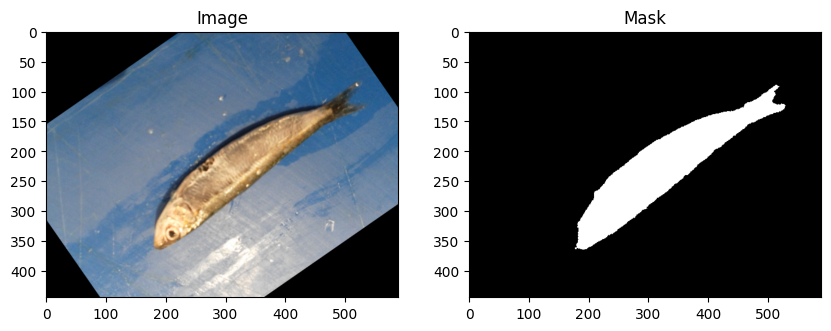

In [71]:
image1 = Image.open('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00001.png')
image2 = Image.open('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00001.png')

# Create a figure with two subplots
plt.figure(figsize=(10, 5))

# Plot the first image on the left
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Image')

# Plot the second image on the right
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('Mask')

Text(0.5, 1.0, 'Mask')

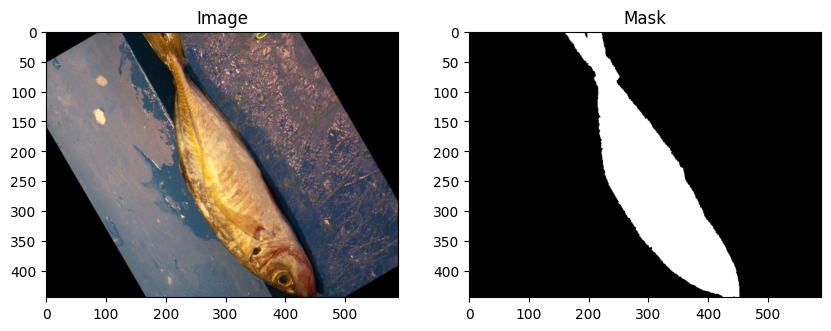

In [72]:
image1 = Image.open('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00003.png')
image2 = Image.open('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel GT/00003.png')

# Create a figure with two subplots
plt.figure(figsize=(10, 5))

# Plot the first image on the left
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Image')

# Plot the second image on the right
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('Mask')

In [73]:
pixels = np.array(image1)

# Find the maximum pixel value
max_pixel_value = pixels.max()
min_pixel_value = pixels.min()

print('Image Size:', image1.size)
print('Max pixel value:', max_pixel_value)
print('Max pixel value:', min_pixel_value)

Image Size: (590, 445)
Max pixel value: 255
Max pixel value: 0


In [74]:
# Reading the 'README.txt' file under Fish Dataset

f = open('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/README.txt', 'r')
content = f.read()
print(content)
f.close()

*** A Large-Scale Dataset for Segmentation and Classification ***

Authors: O. Ulucan, D. Karakaya, M. Turkan
Department of Electrical and Electronics Engineering, Izmir University of Economics, Izmir, Turkey
Corresponding author: M. Turkan
Contact Information: mehmet.turkan@ieu.edu.tr


***General Introduction***

This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey
for a university-industry collaboration project at Izmir University of Economics, and this work
was published in ASYU 2020.
Dataset includes, gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, 
black sea sprat, striped red mullet, trout, shrimp image samples. 

If you use this dataset in your work, please consider to cite:

@inproceedings{ulucan2020large,
  title={A Large-Scale Dataset for Fish Segmentation and Classification},
  author={Ulucan, Oguzhan and Karakaya, Diclehan and Turkan, Mehmet},
  booktitle={2020 Innovations in Intelligent Systems and Application

**Let us do classification first, then go to segmentation**

In [4]:
class_names = os.listdir('/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset')
class_names

['Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Red Sea Bream',
 'Horse Mackerel',
 'Gilt Head Bream']

In [76]:
from sklearn.model_selection import train_test_split

training_df,testing_df = train_test_split(Images_df,test_size=0.2,shuffle=True,random_state=1)

print('The dimension of training data :',training_df.shape)
print('The dimension of testing data :',testing_df.shape)

The dimension of training data : (7200, 2)
The dimension of testing data : (1800, 2)


In [77]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the Image Data Generator
train_datagen  = ImageDataGenerator(rescale = 1./255, validation_split=0.25)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Create generators for training and validation sets
train_generator = train_datagen.flow_from_dataframe(
    training_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224, 224),    
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    subset='training',
)

val_generator = train_datagen.flow_from_dataframe(
    training_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
)

test_generator = test_datagen.flow_from_dataframe(
    testing_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    shuffle=False,
)

Found 5400 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [78]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix,classification_report

def create_classification_model(IPS = (224, 224, 3)):

    base_model = VGG16(
        input_shape=(224,224,3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = False # Make it untrainable
    
    Inputs = base_model.input

    x = L.Dense(128, activation="relu", name="DL-1")(base_model.output)
    x = L.Dense(128, activation="relu", name="DL-2")(x)
    x = L.BatchNormalization(name="BatchNormalisation")(x)
    x = L.Dense(64,activation='relu', name="DL-3")(x)
    
    Outputs = L.Dense(len(class_names), activation="softmax", name="Output_Layer")(x)
    
    model = Model(Inputs, Outputs, name="Classification_Model")
    
    return model

In [79]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [80]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [81]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

In [82]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,# if val loss decreases for 3 epochs in a row, stop training
                                                  restore_best_weights = True) 

# reduce learning rate when a metric has stopped improving
reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=0,factor=0.1)

# Callback to save the Keras model or model weights at some frequency.
model_check_point=ModelCheckpoint(monitor='val_accuracy',filepath='./bestmodel.h5',save_best_only=True,verbose=True)

In [83]:
with strategy.scope():
    Classification_Model = create_classification_model(IPS = (224, 224, 3))

Classification_Model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "Classification_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                               

In [84]:
Classification_Model.compile(loss = "categorical_crossentropy",
                            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                            metrics = ["accuracy"])


History_Classification = Classification_Model.fit(train_generator,
                                                  epochs = 15,
                                                  batch_size = 32,
                                                  steps_per_epoch = len(train_generator),
                                                  validation_data = val_generator,
                                                  validation_steps = len(val_generator),
                                                  callbacks=[early_stopping,reduce_lr,model_check_point])

Epoch 1/15
169/169 [==============================] - ETA: 0s - loss: 1.6070 - accuracy: 0.4885
Epoch 1: val_accuracy improved from -inf to 0.57667, saving model to ./bestmodel.h5
169/169 [==============================] - 96s 540ms/step - loss: 1.6070 - accuracy: 0.4885 - val_loss: 1.9447 - val_accuracy: 0.5767 - lr: 1.0000e-04
Epoch 2/15
169/169 [==============================] - ETA: 0s - loss: 0.8830 - accuracy: 0.7830
Epoch 2: val_accuracy improved from 0.57667 to 0.80500, saving model to ./bestmodel.h5
169/169 [==============================] - 78s 463ms/step - loss: 0.8830 - accuracy: 0.7830 - val_loss: 1.2937 - val_accuracy: 0.8050 - lr: 1.0000e-04
Epoch 3/15
169/169 [==============================] - ETA: 0s - loss: 0.5622 - accuracy: 0.8702
Epoch 3: val_accuracy improved from 0.80500 to 0.89111, saving model to ./bestmodel.h5
169/169 [==============================] - 77s 458ms/step - loss: 0.5622 - accuracy: 0.8702 - val_loss: 0.6476 - val_accuracy: 0.8911 - lr: 1.0000e-04
E

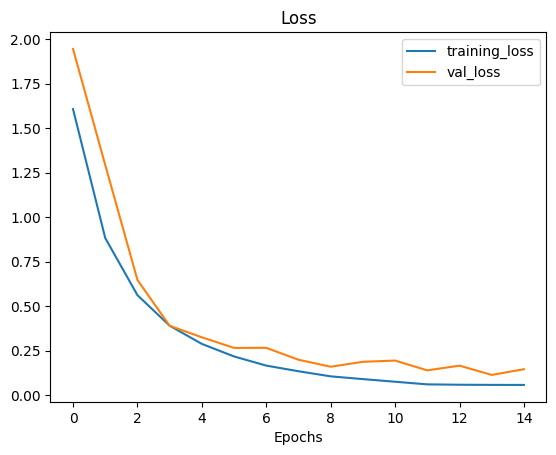

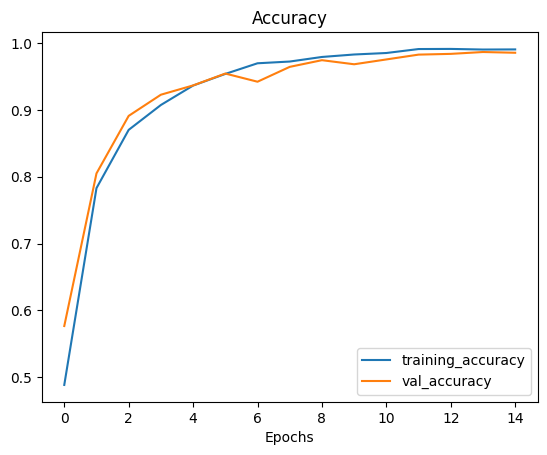

In [85]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(History_Classification)

In [92]:
print(testing_df.shape)
print(len(testing_df['Label'].values))
true_labels = testing_df['Label'].values

(1800, 2)
1800


In [97]:
true_labels

array(['Black Sea Sprat', 'Striped Red Mullet', 'Trout', ..., 'Trout',
       'Gilt-Head Bream', 'Gilt-Head Bream'], dtype=object)

In [93]:
preds = Classification_Model.predict(test_generator)

57/57 [==============================] - 26s 457ms/step


In [95]:
preds = np.argmax(preds,axis=1)

In [119]:
from sklearn.metrics import accuracy_score
import seaborn as sns

true_labels = train_generator.class_indices
true_labels = dict((value,key) for key,value in true_labels.items())
prediction = [true_labels[key] for key in preds]

y_true = testing_df['Label'].values

print(classification_report(y_true,prediction))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      0.98      0.99       200
   Gilt-Head Bream       0.98      0.96      0.97       202
   Hourse Mackerel       1.00      1.00      1.00       212
        Red Mullet       0.96      0.98      0.97       192
     Red Sea Bream       0.97      0.98      0.98       183
          Sea Bass       1.00      0.99      1.00       205
            Shrimp       0.98      0.99      0.98       202
Striped Red Mullet       0.97      0.97      0.97       214
             Trout       0.99      0.99      0.99       190

          accuracy                           0.98      1800
         macro avg       0.98      0.98      0.98      1800
      weighted avg       0.98      0.98      0.98      1800



In [121]:
print(accuracy_score(y_true,prediction))

0.9827777777777778


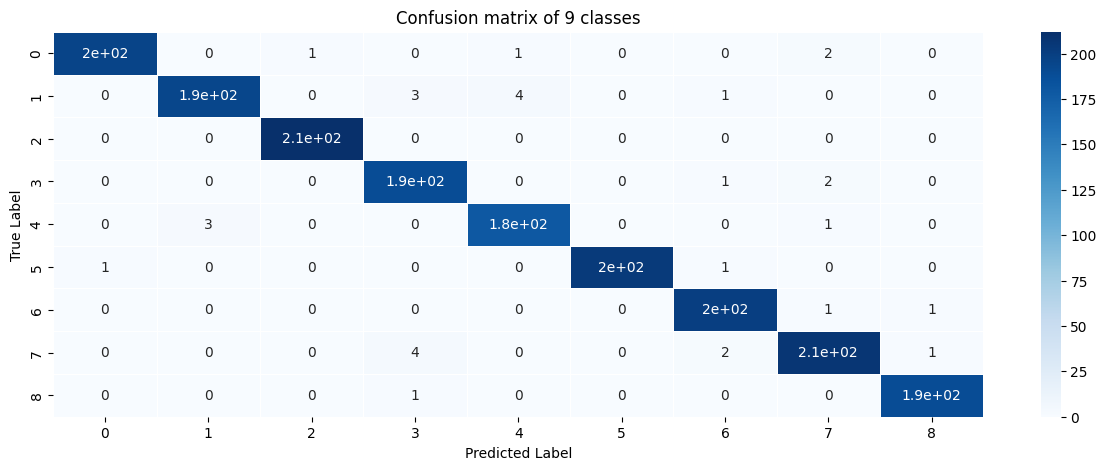

In [120]:
cm=confusion_matrix(y_true,prediction)
plt.figure(figsize=(15,5))
sns.heatmap(cm,annot=True,cmap='Blues',linewidths=0.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion matrix of 9 classes')
plt.show()

In [5]:
data_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

for class_name in class_names:
#     print(class_name)
#     print(os.path.join(data_dir, class_name, class_name))
    print(os.path.join(data_dir, class_name, (class_name+" GT")))

/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass GT
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet GT
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Trout/Trout GT
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Striped Red Mullet/Striped Red Mullet GT
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp GT
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream GT
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Horse Mackerel/Horse Mackerel GT
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Gilt Head Bream/Gilt Head Bream GT


In [6]:
exclude_files

['Segmentation_example_script.m', 'README.txt', 'license.txt']

**Now let us go to segmentation**

In [7]:
# Define the path to your data directory
data_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Get the list of class names
class_names = os.listdir(data_dir)

# Create empty lists to store the file paths
image_paths = []
mask_paths = []

# Iterate over the class names
for class_name in class_names:
    if class_name not in exclude_files:
        # Get the path to the image directory
        image_dir = os.path.join(data_dir, class_name, class_name)
        # Get the path to the mask directory
        mask_dir = os.path.join(data_dir, class_name, (class_name + " GT"))

        # Get the file names in the image directory
        image_files = os.listdir(image_dir)
        # Get the file names in the mask directory
        mask_files = os.listdir(mask_dir)
        
        # Add image paths and mask paths to 2 lists
        for i in range (len(image_files)):
            image_paths.append(os.path.join(image_dir, image_files[i]))
            mask_paths.append(os.path.join(mask_dir, mask_files[i]))

In [8]:
print(image_paths[1220], '\n', mask_paths[1220])
print(len(image_paths), len(mask_paths))

/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00064.png 
 /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT/00064.png
9000 9000


In [9]:
from keras.utils import load_img, img_to_array
import imageio.v2 as imageio
from skimage import exposure
from PIL import Image

def load_img(img_list):
    
    images = []
    for i in img_list:
        # Path to the PNG image file
        image_path = i

        # Read the PNG image using imageio
        image_array = imageio.imread(image_path)
        
        # Resize the image using PIL
        resized_image = Image.fromarray(image_array).resize((224, 224))
        
        # Convert the PIL Image object to NumPy array
        resized_image = np.array(resized_image)

        # Normalize the image using skimage
        normalized_image = exposure.rescale_intensity(resized_image, in_range='image', out_range=(0, 1))
        
        # Append the image to list
        images.append(resized_image)
        
    images = np.array(images)
    return (images)

def custom_data_generator(img_list, msk_list, batch_size):
    
    L = len(img_list)
    i = 0
    
    while True:  
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:         
            limit = min(batch_end, L)
            
            X = load_img(img_list[batch_start:limit])
            Y = load_img(msk_list[batch_start:limit])
            
            yield(X,Y) # A tuple with two numpy arrays with batch_size samples 
            
            batch_start += batch_size   
            batch_end += batch_size

In [10]:
# Split the data into train and test sets
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=1)

# Split the train set into train and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(train_image_paths, train_mask_paths, test_size=0.2, random_state=1)

In [11]:
print("Train samples:", len(train_image_paths))
print("Validation samples:", len(val_image_paths))
print("Test samples:", len(test_image_paths))

Train samples: 5760
Validation samples: 1440
Test samples: 1800


In [12]:
5760+1440+1800

9000

In [14]:
# Usage
batch_size = 32

# Create an instance of the custom data generator
train_generator = custom_data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = custom_data_generator(val_image_paths, val_mask_paths, batch_size)
test_generator = custom_data_generator(test_image_paths, test_mask_paths, batch_size)

In [15]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [16]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [17]:
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.metrics import MeanIoU


################################################################
def conv_block(x, num_filters):
    
    x = L.Conv2D(num_filters, (3,3), padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, (3,3), padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):

    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2,2))(x)

    return x,p

def attention_gate(g, s, num_filters):

    Wg = L.Conv2D(num_filters, (1,1), padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, (1,1), padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg+Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out*s

def decoder_block(x, s, num_filters):

    x = L.UpSampling2D(size=(2,2))(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)

    return x


def attention_unet(input_shape):

    '''Input'''
    inputs = L.Input(input_shape)

    '''Encoder'''
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    '''Decoder'''
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    '''Outputs'''
    outputs = L.Conv2D(1, (1,1), padding="same", activation="sigmoid")(d3)

    '''Model'''
    model = Model(inputs, outputs, name="Attention_UNET")
    return model


#Test if everything is working ok. 
with strategy.scope():
    model = attention_unet((224, 224, 3))

model.summary()

Model: "Attention_UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                    

In [23]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

In [30]:
def dice_loss(y_true, y_pred):
    smooth = 1e-5
    
    # Convert boolean arrays to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    
    return 1.0 - dice_coefficient

def total_loss(dice_weight):
    def loss_function(y_true, y_pred):
        # Compute binary cross-entropy loss
        bce_loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)

        # Compute dice loss
        Dice_loss = dice_loss(y_true, y_pred)

        # Combine the losses using a weighted sum
        total_loss = bce_loss + dice_weight * Dice_loss

        return total_loss
    
    return loss_function

def iou_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + 1e-5)
    
    return iou

In [19]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch == 20:
        lr *= 0.1
    return lr

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [35]:
epochs = 50
learning_rate = 0.001
Batch_Size = 16

decay_rate = learning_rate/epochs

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,
                                    epsilon=None, decay=decay_rate, amsgrad=False)

In [21]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', 
                                                 mode = 'max', restore_best_weights=True),
                tf.keras.callbacks.ModelCheckpoint('fish_seg_unet.hdf5', verbose=1, 
                                                   save_best_only=True), reduce_lr]

In [36]:
model.compile(optimizer=optimizer, loss=total_loss(0.3), metrics=['accuracy', iou_score])

segmentation_history = model.fit(train_generator, 
                                epochs = epochs,
                                batch_size = Batch_Size,
                                steps_per_epoch = len(train_image_paths) // Batch_Size,
                                validation_data = val_generator,
                                validation_steps = len(val_image_paths) // Batch_Size,
                                callbacks=[my_callbacks])

Epoch 1/50
360/360 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9818 - iou_score: 0.8384
Epoch 1: val_loss improved from inf to 0.09335, saving model to fish_seg_unet.hdf5
360/360 [==============================] - 482s 1s/step - loss: 0.0817 - accuracy: 0.9818 - iou_score: 0.8384 - val_loss: 0.0934 - val_accuracy: 0.9774 - val_iou_score: 0.8355 - lr: 0.0010
Epoch 2/50
360/360 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9851 - iou_score: 0.8850
Epoch 2: val_loss improved from 0.09335 to 0.05948, saving model to fish_seg_unet.hdf5
360/360 [==============================] - 403s 1s/step - loss: 0.0599 - accuracy: 0.9851 - iou_score: 0.8850 - val_loss: 0.0595 - val_accuracy: 0.9857 - val_iou_score: 0.8846 - lr: 0.0010
Epoch 3/50
360/360 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9866 - iou_score: 0.8962
Epoch 3: val_loss improved from 0.05948 to 0.05793, saving model to fish_seg_unet.hdf5
360/360 [========

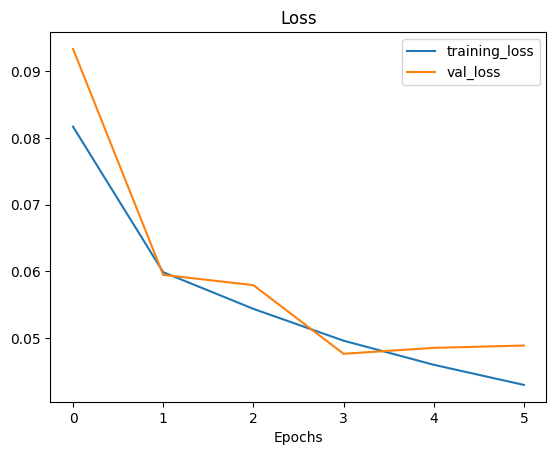

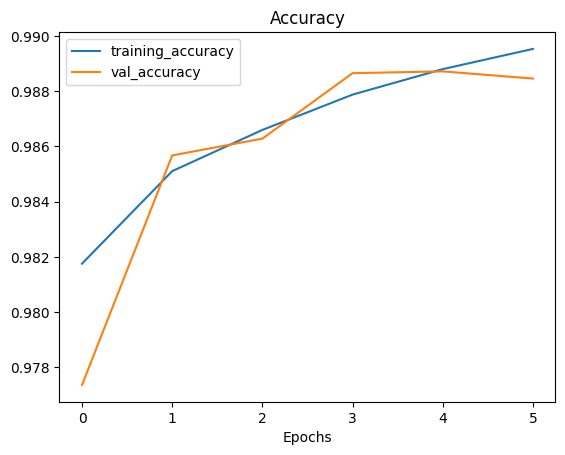

In [37]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(segmentation_history)

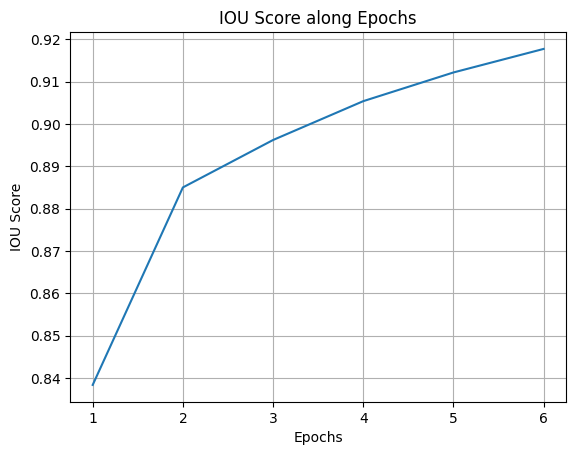

In [41]:
iou_scores = segmentation_history.history['iou_score']
epochs = list(range(1, len(iou_scores) + 1))

plt.plot(epochs, iou_scores)
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.title('IOU Score along Epochs')
plt.grid(True)
plt.show()